### 의사결정 나무 (DT)
- IF - ElSE 방식의 질문에 대한 답변으로 문제를 해결하는 알고리즘
- 피처(특성) 중에서 선택한 기준으로 데이터 분할
    * 엔트로피 (불순정도) => 낮아지는 방향 
    * 정보이득 : 1 - 엔트로피 => 높아지는 방향
    * 지니계수 : 불평등 수치값 => 낮아지는 방향
- 단점 : 과대적합이 될 가능성 높음! 성능이 좋지 않음
- 장점 : 전처리 영향을 받지 않음 / 직관성이 높음 / 피처들 중 주요 피처 확인 가능
- 주의
    * 여기서의 주요 피처는 데이터 분할을 위한 주요 피처
    * 100% 데이터의 주요 피처가 아닐 수도 있음
      => 다른 검사 (상관계수, 시각화 등등)와 함꼐 평가

[1] 모듈 로딩 및 데이터 준비

In [27]:
# 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
irisDF = pd.read_csv('../data/iris.csv', header = None)
irisDF.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [29]:
irisDF.columns = ['sepal_length','sepal_width', 'petal_length','sepal_width', 'variety']

[2] 학습용 데이터셋 준비 <hr>

[2-1] 피처와 타겟 분리

In [30]:
feature = irisDF[irisDF.columns[:3]]
target = irisDF[irisDF.columns[4]]

[2-2] 훈련용과 테스트용 데이터셋 분리

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, stratify = target, test_size = 0.2)

In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


[3] 기계학습 진행 <hr>
- 타겟 데이터 확인 결과 : 3개의 분류
- 학습 유형 : 지도학습 + 분류
    * 분류 알고리즘 => KNN, LogisticRegression, SVM - SVC, DecisionTree

[3-1] 의사결정 알고리즘으로 분류

In [34]:
from sklearn.tree import DecisionTreeClassifier

In [35]:
# 인스턴스 생성
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [36]:
# 생성된 모델 구조 시각화
from sklearn.tree import export_graphviz

In [37]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [38]:
print(export_graphviz(model, 'iris_dt_model.txt'))
print(export_graphviz(model, 'iris_dt_model.dot'))

# 각 gini 값들이 보인다.

None
None


In [39]:
# DT 모델의 시각화 정보를 dot언어로 작성해서 파일로 저장
print(export_graphviz(model, 'iris_dt_model.dot', feature_names=model.feature_names_in_, class_names = model.classes_, rounded = True, filled = True))

None


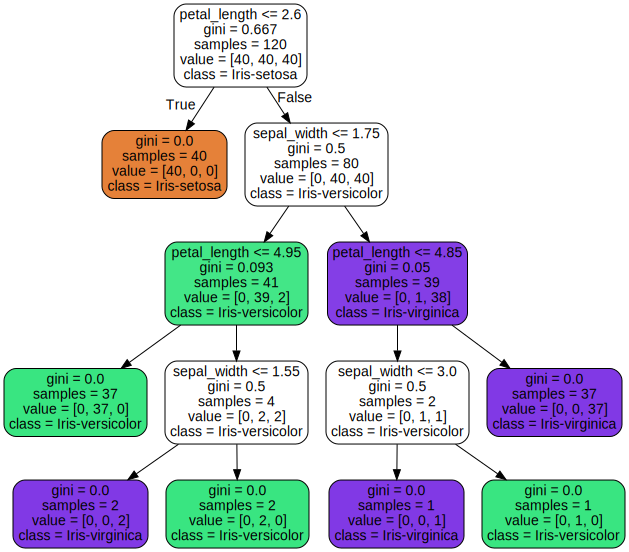

In [40]:
# dot 언어로 작성된 내용을 시각화 해주는 모듈
import graphviz as gz
gz.Source.from_file('./iris_dt_model.dot')

# 클래스 이름 나오냐는 거였고 제일 많이 들어있는게 나오고 기본적으로 숫자가 같으면 젤 먼저 나온거 나온단 얘기였음

[4] 모델 평가

In [41]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(train_score, test_score)

#과대 적합이다.

1.0 0.9333333333333333


[5] 문제 해결 및 성능 향상 즉, 튜닝 <hr>
- 원인 예상
    * 데이터셋 부족 => cv
    * DT의 여러가지 하이퍼 파라미터 기본값으로만 사용 => 다양한 값 조절
- 해결 방법
    * 2개의 원인을 한꺼번에 해결하기 위해서 GridSearchCV
                     

In [42]:
# 모듈 로딩
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [43]:
# 모델 조합 조건
# cv => 기본 5, ...
# DT의 하이퍼파라미터 => max_depth, ..
dt_model = DecisionTreeClassifier()
n_cv = 5
prams = {
         'criterion': ['gini', 'entropy', 'log_loss'],
         'max_depth': [5, 10, 15],
         'min_samples_split':[2, 4, 6]
         }

# 하이퍼파라미터 조합된 모델 생성 후 교차검증 데이터셋으로 학습
# 진행해주는 인스턴스
gs = GridSearchCV(dt_model, param_grid=prams, cv=n_cv)

In [44]:
# 조합된 모델들의 학습 진행
result = gs.fit(X_train, y_train)

In [45]:
# 결과 확인
result

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 4, 6]})

In [46]:
# 학습 후 저장된 모델 파라미터 확인
# 교차학습 결과 => 조합된 모델의 개수만큼 나옴
cv_resultDF = pd.DataFrame(gs.cv_results_)
cv_resultDF

# 모든 조합된 경우의 수가 나옴 => 3 * 3 * 3 = 27

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002010,0.000524,0.001550,0.000645,gini,5,2,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
1,0.001842,0.000417,0.001026,0.000032,gini,5,4,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
2,0.001957,0.000808,0.001027,0.000636,gini,5,6,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.958333,0.916667,0.958333,1.0,0.958333,0.958333,0.026352,1
3,0.002388,0.000438,0.001864,0.000641,gini,10,2,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
4,0.002393,0.000553,0.001289,0.000425,gini,10,4,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
5,0.001982,0.000253,0.001456,0.000521,gini,10,6,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.958333,0.958333,0.026352,1
6,0.001475,0.000552,0.001300,0.000400,gini,15,2,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
7,0.001244,0.000413,0.000823,0.000412,gini,15,4,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10
8,0.001130,0.000230,0.000845,0.000423,gini,15,6,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.958333,0.916667,0.958333,1.0,0.958333,0.958333,0.026352,1
9,0.001427,0.000508,0.001075,0.000110,entropy,5,2,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.958333,0.916667,0.958333,1.0,0.916667,0.950000,0.031180,10


In [47]:
# 조합된 모델 중 최고의 성능을 내는 하이퍼파라미터 값
gs.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 6}

In [48]:
# 조합된 모델 중 최고의 성능을 내는 모델 인스턴스
my_best_model = gs.best_estimator_

In [49]:
# 조합된 모델 중 최고의 점수
gs.best_score_

# mean test score 기준으로 최고를 뽑음

0.9583333333333334

[6] 학습 및 튜닝 후 모델 저장 <hr>
- 다른 파일에서 활용이 가능한 파일 형태로 저장
- 웹/앱 원하는 곳에서 활용 가능
- scikit-learn에서는 pickle 포맷으로 저장
- joblib 모듈에 해당 기능 포함되어 있음

In [50]:
import joblib
import os

In [51]:
# 모델 저장
model_dir = '../model/'
model_filename = model_dir + 'iris_df.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [52]:
joblib.dump(my_best_model, model_filename)

['../model/iris_df.pkl']